In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
data_dir = Path("/kaggle/input/ocr-carplate-datasetv2/OCR-CarPlate-DataSetV2")

if data_dir.exists():
    print("Directory exists")
    print("Contents:")
    print(list(data_dir.iterdir())[:10])  # Print first 10 files
else:
    print("Directory does not exist")

images = sorted(list(map(str, list(data_dir.glob("*.jpg")) + list(data_dir.glob("*.jpeg")))))
labels = [img.split(os.path.sep)[-1].split(".")[0].split("_")[0] for img in images]

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))

Directory exists
Contents:
[PosixPath('/kaggle/input/ocr-carplate-datasetv2/OCR-CarPlate-DataSetV2/29E43417.jpg'), PosixPath('/kaggle/input/ocr-carplate-datasetv2/OCR-CarPlate-DataSetV2/28E36326.jpg'), PosixPath('/kaggle/input/ocr-carplate-datasetv2/OCR-CarPlate-DataSetV2/29Q21117.jpg'), PosixPath('/kaggle/input/ocr-carplate-datasetv2/OCR-CarPlate-DataSetV2/42N99915.jpg'), PosixPath('/kaggle/input/ocr-carplate-datasetv2/OCR-CarPlate-DataSetV2/28M32335.jpg'), PosixPath('/kaggle/input/ocr-carplate-datasetv2/OCR-CarPlate-DataSetV2/19L28525.jpg'), PosixPath('/kaggle/input/ocr-carplate-datasetv2/OCR-CarPlate-DataSetV2/31D74589.jpg'), PosixPath('/kaggle/input/ocr-carplate-datasetv2/OCR-CarPlate-DataSetV2/15H92935.jpg'), PosixPath('/kaggle/input/ocr-carplate-datasetv2/OCR-CarPlate-DataSetV2/28Q71315.jpg'), PosixPath('/kaggle/input/ocr-carplate-datasetv2/OCR-CarPlate-DataSetV2/22E56752.jpg')]
Number of images found:  3587
Number of labels found:  3587


In [5]:
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of unique characters:  30
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'H', 'J', 'L', 'M', 'N', 'P', 'Q', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z', '»']


In [6]:
batch_size = 8
img_width = 256
img_height = 65
downsample_factor = 4
plate_length = len(labels[0])  # Assuming all labels are of the same length
max_length = 8  # Fixed length for labels

In [7]:
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)
print(char_to_num.get_vocabulary())

['[UNK]', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'H', 'J', 'L', 'M', 'N', 'P', 'Q', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z', '»']


In [8]:
train_size = 0.9
images, labels = np.array(images), np.array(labels)
size = len(images)
indices = np.arange(size)
np.random.shuffle(indices)
train_samples = int(size * train_size)
x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]

In [9]:
def pad_label(label):
    return label.ljust(max_length)[:max_length]

y_train = [pad_label(label) for label in y_train]
y_valid = [pad_label(label) for label in y_valid]

def encode_single_sample(img_path, label):
    # Read and preprocess the image
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    label = tf.pad(label, [[0, max_length - tf.shape(label)[0]]], constant_values=0)  # Padding to max_length
    
    return img, label

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

new_shape = (img_width // 16, (img_height // 16) * 256)
nclasses = len(char_to_num.get_vocabulary())

model = keras.models.Sequential([
    layers.Input(shape=(img_width, img_height, 1)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Reshape(target_shape=new_shape),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Conv1D(64, 3, activation="relu", padding="same"),
    layers.MaxPooling1D(2),
    layers.Dropout(0.5),
    layers.Dense(nclasses, activation="softmax")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

epochs = 100
early_stopping_patience = 30
reduce_lr_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=reduce_lr_patience
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
)

# Save the model with the best weights
model.save('ocr_best_model.keras')

Epoch 1/100
 20/404 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1092 - loss: 3.2738 

I0000 00:00:1723232374.110354     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.1573 - loss: 2.7693 - val_accuracy: 0.2876 - val_loss: 2.0789 - learning_rate: 0.0010
Epoch 2/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.3586 - loss: 1.9488 - val_accuracy: 0.6692 - val_loss: 1.0454 - learning_rate: 0.0010
Epoch 3/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6146 - loss: 1.1834 - val_accuracy: 0.8081 - val_loss: 0.6577 - learning_rate: 0.0010
Epoch 4/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7335 - loss: 0.8687 - val_accuracy: 0.8503 - val_loss: 0.4890 - learning_rate: 0.0010
Epoch 5/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7988 - loss: 0.6596 - val_accuracy: 0.9042 - val_loss: 0.3816 - learning_rate: 0.0010
Epoch 6/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8366 - loss: 0.5460 - val_accuracy: 0.9070 - val_loss: 0.3296 - learning_rate: 0.0010
Epoch 7/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8633 - loss: 0.4727 - va

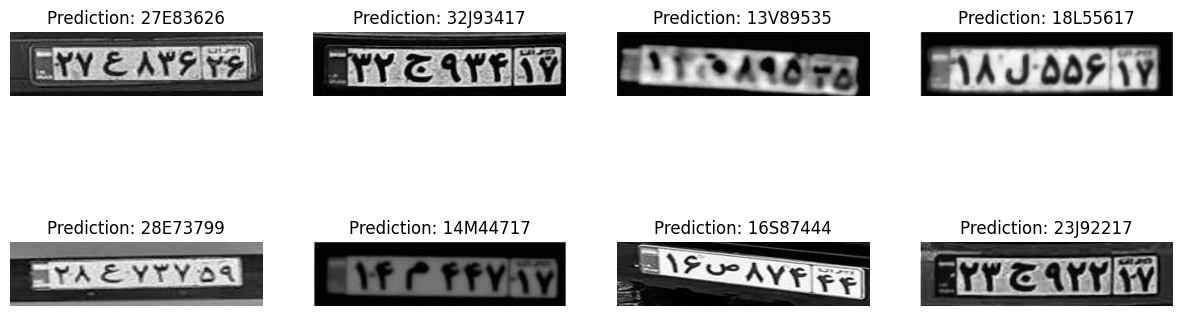

In [10]:
for batch in validation_dataset.take(1):
    batch_images = batch[0]
    batch_labels = batch[1]

    preds = model.predict(batch_images, verbose=0)
    preds = preds.argmax(axis=-1)

    pred_texts = []
    for p in preds:
        label = tf.strings.reduce_join(num_to_char(p)).numpy().decode("utf-8")
        pred_texts.append(label)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(2, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

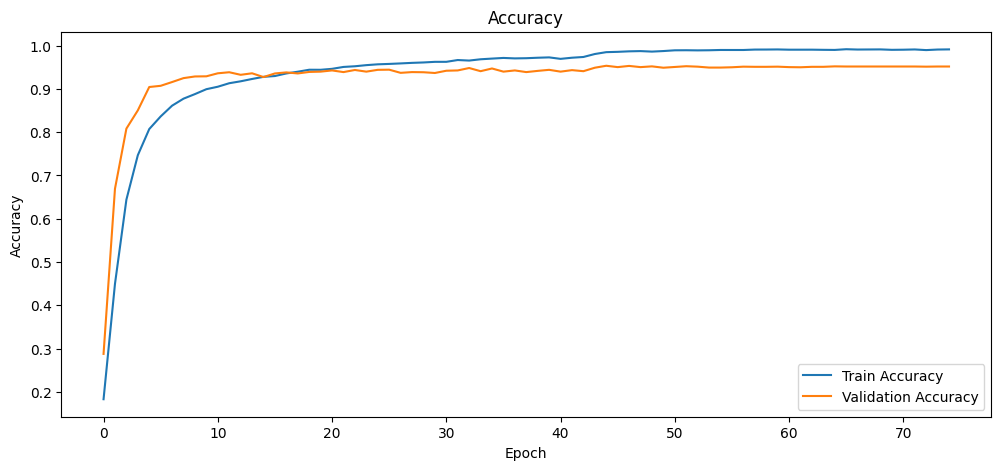

In [11]:
plt.figure(figsize=(12, 5))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

In [12]:
# Load the model from the specified path
model = keras.models.load_model('/kaggle/working/ocr_best_model.keras')

# Verify the model is loaded correctly
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 65, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 8, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 4, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 16, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8, 31)          │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,637,087 (6.24 MB)

 Trainable params: 545,695 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,091,392 (4.16 MB)

In [13]:
# Path to the image
image_path = '/kaggle/input/ocr-persian-car-plate-dataset/OCR-CarPlate-DataSet/11B49837.jpg'

# Preprocess the image
img = tf.io.read_file(image_path)
img = tf.io.decode_jpeg(img, channels=1)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, [img_height, img_width])
img = tf.transpose(img, perm=[1, 0, 2])
img = tf.expand_dims(img, axis=0)  # Add batch dimension

In [14]:
# Predict
pred = model.predict(img)
pred = pred.argmax(axis=-1)

# Convert prediction back to text
predicted_label = tf.strings.reduce_join(num_to_char(pred)).numpy().decode("utf-8")

# Print the predicted label
print(f"Predicted label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label: 11B49837


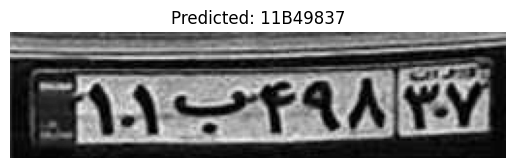

In [15]:
# Convert image for visualization
img_visual = (img.numpy()[0] * 255).astype("uint8")

# Plot the image
plt.imshow(img_visual[:, :, 0].T, cmap="gray")
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()